# Acknowledgement
### This Notebook has been realised owing to the tutorial series by Valerio Velardo. The playlist can be found at https://www.youtube.com/channel/UCZPFjMe1uRSirmSpznqvJfQ/playlists under the title "Deep Learning (for Audio) with python. His tutorial involved genre-classification among 10 classes. 
I modified his work for my mood-classification among 4 classes task. However, the deep learning architecture used was not influenced by his tutorial. His main influence has been in user defined functions for saving and loading data with preprocessing the data, and ploting the history curve. Valerio has been made aware of me using his tutorial for my project through LinkedIn. He even undertook my survey and had like a post regarding my project on LinkedIn

# Load Google Drive(s)

In [ ]:
## Use the account 
## Email: arvind.final.dissertation@gmail.com
## Password: final paper

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# !sudo mkdir /content/drive1
# !google-drive-ocamlfuse /content/drive1

# Libraries

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plot
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import Conv2D, MaxPooling2D, Input, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2

#Sci-kit learn libs
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# User Defined Function

In [ ]:
def json_load(json_path):
    """Loads the pre-processessed json file.

        json_path: Path to json file containing data
        X : MFFC array
        y : encoded labels
        mapping: corresponding labels
    """

    with open(json_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    mapping = data["mapping"]
    return X, y, mapping

In [ ]:
def viz_history(history):
    """Plots accuracy-vs-epoch and error-vs-epoch plots with 

        :param history: Training history of model
        :return:
    """

    figure, axes = plot.subplots(figsize=(10,4), nrows=1, ncols=2)
    figure.tight_layout(pad=3.0)
    
    axes[0].set_xlabel("Epoch")
    axes[1].set_xlabel("Epoch")

    # create accuracy sublpot
    axes[0].plot(history.history["accuracy"], label="Train Accuracy")
    axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend(loc="upper right")
    axes[0].set_title("Accuracy-vs-Epoch")

    # create error sublpot
    axes[1].plot(history.history["loss"], label="Train Error")
    axes[1].plot(history.history["val_loss"], label="Validation Error")
    axes[1].set_ylabel("Error")    
    axes[1].legend(loc="upper right")
    axes[1].set_title("error-vs-epoch")

    plot.show()


In [ ]:
def train_val_test(validation_split, test_split):
    """Loads data and splits it into train, validation and test sets.

        In AER splits, Validation_split of 0.1 and test_split of 0.1 is used ----> train:0.8,val:0.09,test:0.1
        The above split produced the highest accuracies
    """

    # load data
    X, y, mapping = json_load(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42, stratify = y)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_split, random_state=42, stratify = y_train)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, mapping

In [ ]:
    def inception_layer_with_VGG(input_incpetion):  
    # """Returns the output of the inception module. It use two 3x3 filters in place of one 5x5 filter, inspired from the VGG paper. 

    #     :param input_inception: The inception modules input
    #     :retun output_inception: Output of the inception module

    #     The below code has been adapted from a tutorial by Maël Fabian at: https://maelfabien.github.io/deeplearning/inception/#
    # """

    # Regularization penalty
      reg = 0.00001

      # 1st Arm
      inception1 = Conv2D(96, (1,1), padding='same', activation='relu', bias_regularizer= l2(reg), kernel_regularizer=l2(reg))(input_incpetion)
      inception1 = Conv2D(128, (3,3), padding='same', activation='relu', bias_regularizer= l2(reg), kernel_regularizer=l2(reg))(inception1)

      # 2nd Arm
      inception2 = Conv2D(16, (1,1), padding='same', activation='relu', bias_regularizer= l2(reg), kernel_regularizer=l2(reg))(input_incpetion)
      ## VGG effect
      inception2 = Conv2D(32, (3,3), padding='same', activation='relu', bias_regularizer= l2(reg), kernel_regularizer=l2(reg))(inception2)
      inception2 = Conv2D(32, (3,3), padding='same', activation='relu', bias_regularizer= l2(reg), kernel_regularizer=l2(reg))(inception2)

      # 3rd Arm
      inception3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_incpetion)
      inception3 = Conv2D(32, (1,1), padding='same', activation='relu', bias_regularizer= l2(reg), kernel_regularizer=l2(reg))(inception3)

      # 4th Arm
      inception4 = Conv2D(64, (1,1), padding = 'same', activation = 'relu', bias_regularizer= l2(reg), kernel_regularizer=l2(reg))(input_incpetion)

      # Concatenated output
      output_inception = tf.keras.layers.concatenate([inception1, inception2, inception3, inception4], axis = 3)

      return(output_inception)

In [ ]:
def build_model_inception_with_vgg(shape_of_input):
    """Generates Inception V model

    :param shape_of_input: tuple with the Shape of input set
    :return model: Inception-V1-Aux2 output
    """

    # mish is an activation function similar to swish that improved the model accuracy when used in the dense layers
    def mish(x):
      return x * keras.backend.tanh(keras.backend.softplus(x))

      
    input_img = Input(shape=shape_of_input)
    num_classes = 4 #specific to the problem in hand

    layer_1 = Conv2D(64, (7,7), padding='same', strides = (2,2), activation='relu')(input_img)
    layer_1 = MaxPooling2D((3,3), strides=(2,2), padding='same')(layer_1)
    layer_1 = BatchNormalization()(layer_1)
    layer_1 = Conv2D(64, (1,1), padding = 'valid', activation = 'relu', strides = (1,1))(layer_1)
    layer_1 = Conv2D(192, (3,3), padding = 'same', activation = 'relu', strides = (1,1))(layer_1)
    layer_1 = MaxPooling2D((3,3), strides=(2,2), padding='same')(layer_1)

    output_1 = layer_1

    #####
    inception3a = inception_layer(output_1)
    inception3b = inception_layer(inception3a)

    inception4a = inception_layer(inception3b)
    inception4b = inception_layer(inception4a)
    inception4c = inception_layer(inception4b)
    inception4d = inception_layer(inception4c)
    inception4e = inception_layer(inception4d)

    mid_4e = MaxPooling2D((3,3), strides=(2,2), padding='same')(inception4e)
    mid_4e = Dropout(0.5)(mid_4e)

    inception5a = inception_layer(mid_4e)
    inception5b = inception_layer(inception5a)
    inception5c = inception_layer(inception5b)
    inception5_output1 = AveragePooling2D((5,5), strides = (3,3), padding = 'same')(inception5c)
    mid_4e = Dropout(0.5)(mid_4e)
    inception5_output1 = Conv2D(128, (1,1), strides = (1,1), activation = mish, padding = 'same')(inception5_output1)
    
    flat_1= Flatten()(inception5_output1)
    dense1_output1 = Dense(512, activation= mish)(flat_1)
    dense1_output1 = Dense(512, activation= mish)(dense1_output1)
    dense1_output1 = Dropout(0.7)(dense1_output1)
    output0 = Dense(num_classes, activation='softmax')(dense1_output1)

    model = Model([input_img], output0)
    return model


In [ ]:
def load_model(model_path):
      """Loads model from the given path
        :param model_path: route to the desired model
        :return model: return the loaded model
      """
      
      def mish(x):
        return x * keras.backend.tanh(keras.backend.softplus(x))

      model= keras.models.load_model(model_path,
                        custom_objects = {"mish":mish})

      return model

In [ ]:
def predict_AER(X_predict):
    """Gives the AER prediction of the loaded model.
      
      :param X_predict: the instance to predict
    """
    X = X_predict
    X= X[np.newaxis, ...] # array shape (1, 130, 13, 1)
    label_dict = {}
    for i in range(len(mapping)):
      label_dict.update({i:mapping[i]})
    label_dict

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    print("The predicted mood is:", label_dict[predicted_index[0]])

In [ ]:
def metrics_all(model, X_test, y_test):
    """Provides different metrices to assess.

      :param X_test: The set of instances to predict on
      :param Y_test: Ground truth labels
    """

    yhat_probs = model.predict(X_test, verbose=0) #class probability prediction
    yhat_classes = np.argmax(yhat_probs, axis =1) #predicted class


    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes, average='weighted')
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes, average='weighted')
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes, average='weighted')
    print('F1 score: %f' % f1)

    # Confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    print("\nThe confusion matrix is as below:")
    print(matrix)

In [ ]:
def accuracy_per_class(preds, labels):
    """
    Provides the accuracy for each class in the AER task

    :param preds: Predicted labels
    :param labels: Ground truth labels
    """

    label_dict = {} #dictionary to map the encoded labels to their semantic labels
    for i in range(len(mapping)):
      label_dict.update({i:mapping[i]})
      
    for label in np.unique(y_test):
        y_preds = yhat_classes[y_test==label]
        y_true = y_test[y_test==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}')
        print(f'Accuracy (Percentage): ', (len(y_preds[y_preds==label])/len(y_true))*100, "%\n")

# Load and Split dataset

In [ ]:
# get train, validation, test splits
JSON_PATH = "/content/drive/My Drive/DEAM JSON/Sample rate:44100, MFCC coefficient:13, Track Duration:45, segments: 20, N0. FFT = 2048"
X_train, X_validation, X_test, y_train, y_validation, y_test, mapping = train_val_test(0.1, 0.1)

# Model Training

In [ ]:
# create network
shape_of_input = (X_train.shape[1], X_train.shape[2], 1)
model = build_model_inception_with_vgg(shape_of_input)

checkpoint = ModelCheckpoint('/content/drive1/Models/AER/Model-best-model-accuracy-inception-v1_Aux2.h5', verbose = 1, monitor='val_accuracy',save_best_only=True, mode='max')
patience = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)


optimiser = tf.keras.optimizers.RMSprop(learning_rate= 0.00005)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='/content/drive1/Architecture Images/inception_aux_2_.png', show_shapes=True, show_layer_names=True)


# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=64, epochs=200, callbacks=[checkpoint,patience])


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 194, 13, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 97, 7, 64)    3200        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 49, 4, 64)    0           conv2d_74[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 49, 4, 64)    256         max_pooling2d_13[0][0]           
_______________________________________________________________________________________


# Plots and Predictions (The Fun Part)

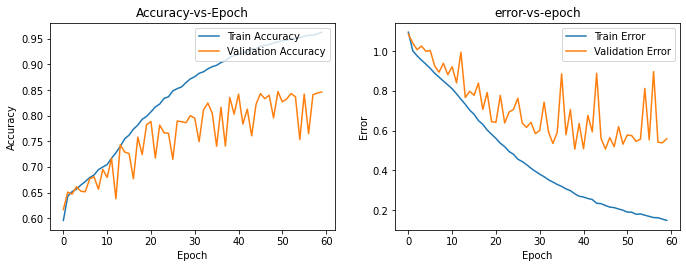

In [ ]:
viz_history(history)

In [ ]:
model = load_model("/content/drive1/Models/AER/Model-best-model-accuracy-inception-v1_test.h5")

OSError: ignored

In [ ]:
predict_AER(X_test[0])

In [ ]:
metrics_all(model,X_test,y_test)

In [ ]:
yhat_probs = model.predict(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis =1)

accuracy_per_class (yhat_classes, y_test)